In [1]:
#!pip install torchxrayvision
#!pip install libauc==1.2.0
import os,sys
sys.path.insert(0,"..")
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import sys
import torch.nn.functional as F
import tqdm
import sklearn, sklearn.metrics
import pandas as pd
import torchxrayvision as xrv
import skimage
import cv2
from PIL import Image
from libauc.models import densenet121 as DenseNet121
from libauc.datasets import CheXpert
# tempfile
from tempfile import NamedTemporaryFile

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Image conversion functions

Every part in the pipeline (autoencoder, classifier, etc.) expects a different input format. The following functions convert between the different formats.

In [63]:


def load_img(path):    
    image = cv2.imread(path, 0)
    image = Image.fromarray(image)
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    # resize and normalize; e.g., ToTensor()
    image = cv2.resize(image, dsize=(224,224), interpolation=cv2.INTER_LINEAR)  
    image = image/255.0
    __mean__ = np.array([[[0.485, 0.456, 0.406]]])
    __std__ =  np.array([[[0.229, 0.224, 0.225]]]) 
    image = (image-__mean__)/__std__
    image = image.transpose((2, 0, 1)).astype(np.float32)
    #label = np.array(self.targets[idx]).reshape(-1).astype(np.float32)
    return image#, label

def img_bw_to_classifier(img):
    # img is of shape (224, 224) with values in [0, 1]
    # output is 
    assert img.shape == (224, 224)
    # make 3 channels, shape (224, 224, 3)
    img = torch.stack([img, img, img], axis=2)
    __mean__ = torch.tensor([[[0.485, 0.456, 0.406]]])
    __std__ =  torch.tensor([[[0.229, 0.224, 0.225]]]) 
    img = (img-__mean__)/__std__
    # transpose to (3, 224, 224)
    img = img.permute(2, 0, 1).float()
    return img

def xrv_img_to_classifier(img):
    # img is of shape (224, 224) with values in [-1024, 1024]
    """
    if not isinstance(img, np.ndarray):
        img = img.detach()
    with NamedTemporaryFile(suffix=".png") as f:
        plt.imsave(f.name, img, cmap="Greys_r")
        img = load_img(f.name)
    return torch.tensor(img)
    """
    return img_bw_to_classifier(img)

def xrv_img_to_classifier_batch0(img):
    # img is of shape (0, 1, 224, 224) with values in [-1024, 1024]
    # returns (1, 3, 224, 224)
    cf_img = xrv_img_to_classifier(img[0, 0])
    cf_img = cf_img[None]
    return cf_img

def normalize_img(img):
    # returns values [-1024, 1024]
    chexpert_img = xrv.datasets.normalize(img, 255)
    chexpert_img = chexpert_img[None, :, :]
    transform = torchvision.transforms.Compose([
        xrv.datasets.XRayCenterCrop(),
        xrv.datasets.XRayResizer(224),
    ])
    chexpert_img = transform(chexpert_img)
    chexpert_img = torch.from_numpy(chexpert_img).unsqueeze(0)
    return chexpert_img

def norm_01(img):
    img = img - img.min()
    img = img / img.max()
    return img

def plot_cf_img(img):
    img = img.permute(1, 2, 0)
    img = img.cpu().detach().numpy()
    gb_img = (img - np.min(img)) / (np.max(img) - np.min(img))
    plt.imshow(gb_img)
    plt.show()



Shape: (320, 320)
[[35 28 19]
 [12  8  3]
 [ 4  2  1]]


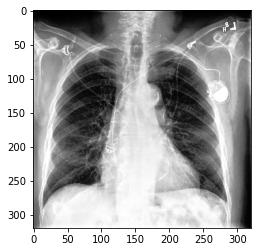

Setting XRayResizer engine to cv2 could increase performance.
Shape: torch.Size([1, 1, 224, 224])
tensor([[[[ -793.4062,  -875.5726,  -949.6147],
          [ -973.5838, -1003.2648, -1018.4674],
          [-1009.0696, -1020.5575, -1015.3950]]]])


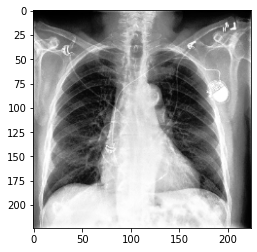

Shape: torch.Size([3, 224, 224])
tensor([[-1.6262, -1.8014, -1.9593],
        [-2.0104, -2.0737, -2.1061],
        [-2.0861, -2.1106, -2.0996]])


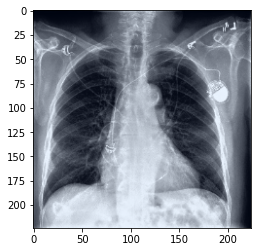

In [64]:
colab = False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset_path = "/content/CheXpert/" if colab else "."
img_path = f"{dataset_path}/CheXpert-v1.0-small/valid/patient64606/study1/view1_frontal.jpg"
chexpert_img = skimage.io.imread(img_path)


print(f"Shape: {chexpert_img.shape}\n{chexpert_img[:3, :3]}")
plt.imshow(chexpert_img, cmap="Greys_r"); plt.show();

xrv_img = normalize_img(chexpert_img)
img_01 = norm_01(xrv_img)

print(f"Shape: {xrv_img.shape}\n{xrv_img[:, :, :3, :3]}")
plt.imshow(xrv_img[0, 0], cmap="Greys_r"); plt.show();

img_cf = xrv_img_to_classifier(img_01[0, 0])
print(f"Shape: {img_cf.shape}\n{img_cf[0, :3, :3]}")
plot_cf_img(img_cf)

# Autoencoders

### XRV Autoencoder

input image: torch.Size([1, 1, 224, 224]), min: 0.0, max: 1.0
latent image shape: torch.Size([1, 512, 3, 3]), min: 0.0, max: 17.713882446289062
restored image shape: (1, 1, 224, 224), min: 0.0, max: 1.0


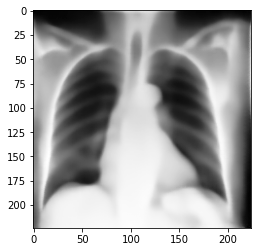

In [109]:
ae_xrv_raw = xrv.autoencoders.ResNetAE(weights="101-elastic")
# instead of using images with pixel values in [-1024, 1024], we use images with pixel values in [0, 1]
class ResNetAE_01():
    def __init__(self, raw_ae):
        self.encoder = raw_ae.encode
        self.decoder = raw_ae.decode

    def encode(self, x):
        x = norm_01(x)
        # make it (batch, 1, 224, 224) with values in [-1024, 1024]
        x*=1024*2
        x-=1024
        return self.encoder(x)
    def decode(self, z):
        x =  self.decoder(z)
        x/=1024*2
        x+=1024
        x = norm_01(x)
        return x

ae_xrv = ResNetAE_01(ae_xrv_raw)



print(f"input image: {img_01.shape}, min: {img_01.min()}, max: {img_01.max()}")
z = ae_xrv.encode(img_01)
print(f"latent image shape: {z.shape}, min: {z.min()}, max: {z.max()}")
decoded = ae_xrv.decode(z).detach().numpy()
print(f"restored image shape: {decoded.shape}, min: {decoded.min()}, max: {decoded.max()}")
plt.imshow(decoded[0][0], cmap="Greys_r")

### Autoencoder v2

input image: torch.Size([1, 1, 224, 224]), min: 0.0, max: 1.0
latent image shape: torch.Size([1, 512, 7, 7]), min: 0.0, max: 0.3794429898262024
restored image shape: (1, 1, 224, 224), min: 0.0, max: 1.011147379875183


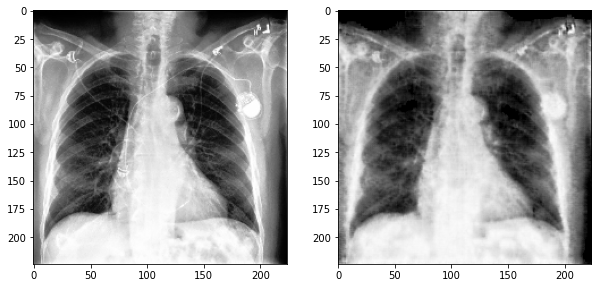

In [65]:

from models.ae_v2 import SegNet, segnetDown2, segnetDown3, conv2DBatchNormRelu, segnetUp2, segnetUp3
ae = torch.load("./weights/autoencoder_v2.pt",  map_location=device);
ae.eval();
print(f"input image: {img_01.shape}, min: {img_01.min()}, max: {img_01.max()}")
z, add = ae.encode(img_01)
print(f"latent image shape: {z.shape}, min: {z.min()}, max: {z.max()}")
img_restore = ae.decode(z, add).detach().numpy()
print(f"restored image shape: {img_restore.shape}, min: {img_restore.min()}, max: {img_restore.max()}")

fig, ax = plt.subplots(1,2, figsize=(10, 10))
ax[0].imshow(img_01[0, 0], cmap='Greys_r')
ax[1].imshow(img_restore[0, 0], cmap='Greys_r')


### 1 channel vnbig Autoencoder

input image: torch.Size([1, 1, 224, 224]), min: 0.0, max: 1.0
latent image shape: torch.Size([1, 64, 7, 7]), min: 0.0, max: 0.9601438045501709
restored image shape: (1, 1, 224, 224), min: 0.0, max: 1.2200154066085815
img_restore_norm image shape: (1, 1, 224, 224), min: 0.0, max: 1.0
loss 0.0028910357505083084
loss norm 0.0028090972919017076


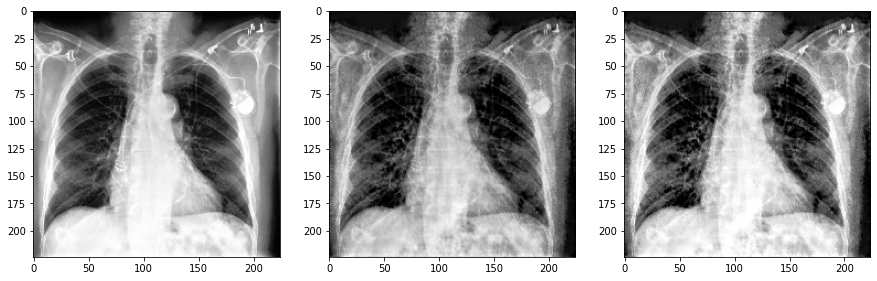

In [119]:

from models.ae_1channel_vinbig import SegNet, segnetDown2, segnetDown3, conv2DBatchNormRelu, segnetUp2, segnetUp3
#importlib.reload(models.ae_1channel_vinbig)
#ae = torch.load("./weights/model_1channel_vinbig.pt",  map_location=device);
ae = torch.load("./weights/model_1channel_finetuned.pt",  map_location=device);
ae.eval()
print(f"input image: {img_01.shape}, min: {img_01.min()}, max: {img_01.max()}")


z, add = ae.encode(img_01)
print(f"latent image shape: {z.shape}, min: {z.min()}, max: {z.max()}")
img_restore = ae.decode(z, add).detach().numpy()
print(f"restored image shape: {img_restore.shape}, min: {img_restore.min()}, max: {img_restore.max()}")

img_restore_norm = img_restore.copy()
img_restore_norm[img_restore_norm>1] = 1
#img_restore_norm = (img_restore_norm - img_restore_norm.min()) / (img_restore_norm.max() - img_restore_norm.min())
print(f"img_restore_norm image shape: {img_restore_norm.shape}, min: {img_restore_norm.min()}, max: {img_restore_norm.max()}")

img_01_np = img_01.cpu().detach().numpy()

print(f"loss {np.mean((img_restore - img_01_np)**2)}")
print(f"loss norm {np.mean((img_restore_norm - img_01_np)**2)}")


fig, ax = plt.subplots(1,3, figsize=(15, 10))
ax[0].imshow(xrv_img[0, 0], cmap='Greys_r')
ax[1].imshow(img_restore[0, 0], cmap='Greys_r')
ax[2].imshow(img_restore_norm[0, 0], cmap='Greys_r');


### AE 32


input image: torch.Size([1, 1, 224, 224]), min: 0.0, max: 1.0
latent image shape: torch.Size([1, 32, 7, 7]), min: 0.0, max: 1.79068124294281
restored image shape: (1, 1, 224, 224), min: 0.0, max: 1.0317741632461548
img_restore_norm image shape: (1, 1, 224, 224), min: 0.0, max: 1.0
loss 0.00042748128180392087
loss norm 0.0004268161137588322


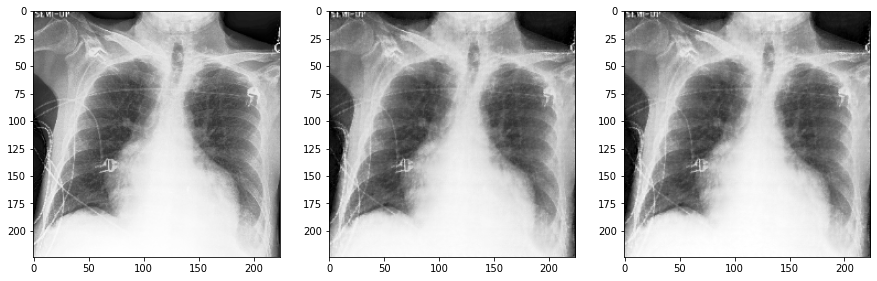

In [151]:
from models.ae_32 import SegNet, segnetDown2, segnetDown3, conv2DBatchNormRelu, segnetUp2, segnetUp3
ae = torch.load("./weights/chexpert_32.pt",  map_location=device);
ae.eval()
print(f"input image: {img_01.shape}, min: {img_01.min()}, max: {img_01.max()}")


z, add = ae.encode(img_01)
print(f"latent image shape: {z.shape}, min: {z.min()}, max: {z.max()}")
img_restore = ae.decode(z, add).detach().numpy()
print(f"restored image shape: {img_restore.shape}, min: {img_restore.min()}, max: {img_restore.max()}")

img_restore_norm = img_restore.copy()
img_restore_norm[img_restore_norm>1] = 1
#img_restore_norm = (img_restore_norm - img_restore_norm.min()) / (img_restore_norm.max() - img_restore_norm.min())
print(f"img_restore_norm image shape: {img_restore_norm.shape}, min: {img_restore_norm.min()}, max: {img_restore_norm.max()}")

img_01_np = img_01.cpu().detach().numpy()

print(f"loss {np.mean((img_restore - img_01_np)**2)}")
print(f"loss norm {np.mean((img_restore_norm - img_01_np)**2)}")


fig, ax = plt.subplots(1,3, figsize=(15, 10))
ax[0].imshow(img_01[0, 0], cmap='Greys_r')
ax[1].imshow(img_restore[0, 0], cmap='Greys_r')
ax[2].imshow(img_restore_norm[0, 0], cmap='Greys_r');

# Classifier

In [67]:
classifier_raw = DenseNet121(pretrained=True, last_activation='sigmoid', activations='relu', num_classes=5) # initialize model

classifier_raw.load_state_dict(torch.load('./weights/trained_auc_model.pt', map_location=device)) # load trained model
classifier_raw.eval();

def classifier(img):
    return classifier_raw(xrv_img_to_classifier_batch0(img))

In [16]:
diseases = {0: 'Cardiomegaly', 1: 'Edema', 2: 'Consolidation', 3: 'Atelectasis', 4: 'Pleural Effusion'}

In [152]:
base_labels = classifier(img_01)
reconstructed_labels = classifier(ae.decode(*ae.encode(img_01)))
#reconstructed_labels = classifier(img_restore)
print(f"Base labels:\n{base_labels.detach().numpy()},\n\nReconstructed labels:\n{reconstructed_labels.detach().numpy()}\n\nloss: {F.mse_loss(base_labels, reconstructed_labels)}")

Base labels:
[[0.739834   0.5320243  0.04538432 0.33286318 0.6950258 ]],

Reconstructed labels:
[[0.79324687 0.6521664  0.04160509 0.2689442  0.63139486]]

loss: 0.005087174475193024


# Grad CAM

In [34]:
def get_saliency(img):
    target_layers = [classifier_raw.features[-1]]
    cam = GradCAMPlusPlus(model=classifier_raw, target_layers=target_layers)

    X = xrv_img_to_classifier_batch0(img)
    grayscale_cam = cam(input_tensor=X)[0]
    #print("cam scale", grayscale_cam.shape)
    return grayscale_cam

# show_saliency(xrv_img)

# Counterfactuals

In [165]:
saliency_threshold = 0.5
mask_weight = 1e6 # this much more penalty for changes outside of the mask
use_xrv=False

def find_counterfactual(input_img, target_labels, target_weight=1e4):
    mask = torch.tensor(get_saliency(input_img))
    
    mask_th = (mask > saliency_threshold).float()

    if use_xrv:
        z_init = ae_xrv.encode(input_img)
        img_r_init = ae_xrv.decode(z_init).detach()
    else:
        z_init, add = ae.encode(input_img)
        img_r_init = ae.decode(z_init, add).detach()
        
    # optimize z
    z = z_init.clone().detach().requires_grad_(True)
    optimizer = torch.optim.Adam([z], lr=0.03)
    for i in range(300):
        optimizer.zero_grad()
        if use_xrv:
            img_r = ae_xrv.decode(z)
        else:
            img_r = ae.decode(z, add)
        
        img_sq_diff = ((img_r - img_r_init)**2)[0, 0]
        # mask 1 -> penalty 1, mask 0 -> penalty mask_weight
        weighted_diff = img_sq_diff * (mask_weight * (1 - mask_th) + mask_th*0)
        loss_reconstruction = torch.mean(weighted_diff)*1e3
        classification_label = classifier(img_r)
        # print(f"Classification label: {classification_label} | Target label: {target_labels}")
        loss_classification = F.mse_loss(classification_label, target_labels)*target_weight*1e3
        loss = loss_reconstruction + loss_classification
        
        if i == 0 or (i+1) % 10 == 0:
            print(f"{i+1:4} Loss: {loss.item():.4f} | Loss reconstruction: {loss_reconstruction.item():.4f} | Loss classification: {loss_classification.item():.4f}")
        
        loss.backward()
        optimizer.step()

    # output image
    if use_xrv:
        img_r = ae_xrv.decode(z).detach().numpy()
    else:
        img_r = ae.decode(z, add).detach().numpy()

    return img_r_init.detach().numpy(), img_r, mask_th


img_path = f"{dataset_path}/CheXpert-v1.0-small/valid/patient64624/study1/view1_frontal.jpg"
input_img_raw = skimage.io.imread(img_path)
input_img = norm_01(normalize_img(input_img_raw))

if use_xrv:
    reconstructed_img = ae_xrv.decode(ae_xrv.encode(img_01))
else:
    reconstructed_img = ae.decode(*ae.encode(img_01))

input_labels = classifier(input_img)
reconstructed_labels = classifier(reconstructed_img)
feature_index = 0 # 0: ?

# flip label
# ideally we want to based off the input labels, but because the AE is not perfect, we use the reconstructed labels
#target_labels = input_labels.clone().detach()
target_labels = reconstructed_labels.clone().detach()
target_labels[0, feature_index] = 0
print(f"Changing label {feature_index} from {input_labels[0, feature_index]} to {target_labels[0, feature_index]}")

img_r_init, img_r, mask_th = find_counterfactual(input_img, target_labels)


reconstructed_labels = classifier(torch.tensor(img_r_init))
counterfactual_labels = classifier(torch.tensor(img_r))

print(f"Input labels:\n{input_labels.detach().numpy()}\n")
print(f"Target labels:\n{target_labels.detach().numpy()}\n")
print(f"Reconstructed labels:\n{reconstructed_labels.detach().numpy()}\n")
print(f"Counterfactual labels:\n{counterfactual_labels.detach().numpy()}\n")

print("Initial loss:", F.mse_loss(target_labels, reconstructed_labels).detach().numpy())
print("Final loss:", F.mse_loss(target_labels, counterfactual_labels).detach().numpy())
print("Initial loss (feature):", F.mse_loss(target_labels[0, feature_index], reconstructed_labels[0, feature_index]).detach().numpy())
print("Final loss (feature):", F.mse_loss(target_labels[0, feature_index], counterfactual_labels[0, feature_index]).detach().numpy())
p_input = input_labels[0, feature_index]
p_rec = reconstructed_labels[0, feature_index]
p_cf = counterfactual_labels[0, feature_index]

fig, ax = plt.subplots(1,3, figsize=(20,10))
#ax[0].imshow(input_img_raw, cmap='Greys_r');    ax[0].set_title("Input image");
ax[0].imshow(input_img[0][0], cmap='Greys_r');  ax[0].set_title(f"Input image\np({diseases[feature_index]})={p_input:.3f}");
ax[1].imshow(img_r_init[0][0], cmap='Greys_r'); ax[1].set_title(f"Initial reconstruction\np({diseases[feature_index]})={p_rec:.3f}");
ax[2].imshow(img_r[0][0], cmap='Greys_r');      ax[2].set_title(f"Conterfactual\np({diseases[feature_index]})={p_cf:.3f}");
ax[2].contour(mask_th, levels=[saliency_threshold], colors='r', linewidths=2);

Setting XRayResizer engine to cv2 could increase performance.
Changing label 0 from 0.5353103280067444 to 0.0
   1 Loss: 680012.5625 | Loss reconstruction: 0.0000 | Loss classification: 680012.5625
  10 Loss: 322455.9375 | Loss reconstruction: 63725.1758 | Loss classification: 258730.7500
  20 Loss: 271360.0000 | Loss reconstruction: 49978.4883 | Loss classification: 221381.5156
  30 Loss: 241893.3125 | Loss reconstruction: 48954.5234 | Loss classification: 192938.7812
  40 Loss: 218692.4688 | Loss reconstruction: 44388.0195 | Loss classification: 174304.4531
  50 Loss: 197757.2188 | Loss reconstruction: 42486.6328 | Loss classification: 155270.5938
  60 Loss: 185724.8750 | Loss reconstruction: 43080.8477 | Loss classification: 142644.0312
  70 Loss: 176155.0312 | Loss reconstruction: 42074.6172 | Loss classification: 134080.4062
  80 Loss: 89952.6094 | Loss reconstruction: 36899.2539 | Loss classification: 53053.3516
  90 Loss: 73826.0938 | Loss reconstruction: 19702.6660 | Loss class

torch.Size([1, 1, 224, 224])
torch.Size([224, 224])
mask 0.0 0.9999999


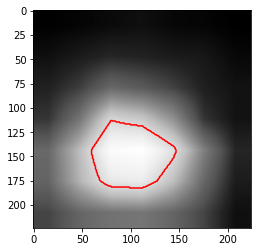

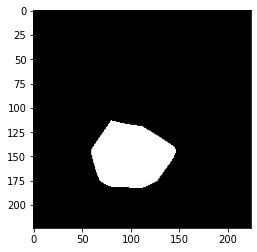

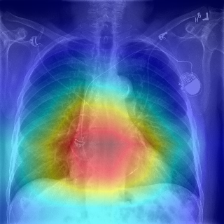

In [91]:

def show_saliency(img, mask):
    print(img.shape)
    # rgb_img = X[index, :, :, :]
    rgb_img = xrv_img_to_classifier(img)
    rgb_img = rgb_img.permute(1, 2, 0)
    rgb_img = rgb_img.cpu().detach().numpy()
    rgb_img = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img))
    visualization = show_cam_on_image(img = rgb_img, mask = mask, use_rgb=True)
    #print(rgb_img.shape)

    
  
    return visualization

print(input_img.shape)
mask = get_saliency(input_img)
threshold = 0.75
mask_th = mask > threshold

# visualize contour level
plt.contour(mask_th, levels=[0.5], colors='r')



vis = show_saliency(input_img[0, 0], mask)
print("mask", mask.min(), mask.max())



plt.imshow(mask, cmap='Greys_r'); plt.show();
plt.imshow(mask_th, cmap='Greys_r'); plt.show();
Image.fromarray(vis, 'RGB')

In [125]:
# find good image:

imgs_nums = [
    64624,
    64673,
]

#imgs_nums = range(64606, 64700)
for img_num in imgs_nums:
    img_path = f"{dataset_path}/CheXpert-v1.0-small/valid/patient{img_num}/study1/view1_frontal.jpg"
    input_img_raw = skimage.io.imread(img_path)
    img_01 = norm_01(normalize_img(input_img_raw))
    base_labels = classifier(img_01)
    reconstructed_labels = classifier(ae.decode(*ae.encode(img_01)))
    print(f"Img {img_num} feature 0: {base_labels[0, 0]:.3f} -> {reconstructed_labels[0, 0]:.3f}")
    if base_labels[0, 0] > 0.5:
        print(f"Found good image: {img_num} --------------------------------")

Setting XRayResizer engine to cv2 could increase performance.
Img 64624 feature 0: 0.535 -> 0.204
Found good image: 64624 --------------------------------
Setting XRayResizer engine to cv2 could increase performance.
Img 64673 feature 0: 0.740 -> 0.176
Found good image: 64673 --------------------------------
